In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mraa
import signal
from functools import wraps
import errno
import os
import re

u = mraa.Uart(0)
u.setBaudRate(115200)

0

# Time Out Decorator

In [2]:
class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)

    return decorator

# Low Level Serial API

In [3]:
'''
Runtime commands are commands that can be sent at any time during controller operation
and are taken into consideration immediately. Runtime commands start with “!” and
are followed by one to three letters. Runtime commands are also used to refresh the
watchdog timer to ensure safe communication. Runtime commands can be called from a
MicroBasic script using the setcommand() function.
'''

# Roboteq Runtime Commands

SET_ACCELERATION = 'AC'
SET_NEXT_ACCELERATION = 'AX'
SET_USER_BOOLEAN_VARIABLE = 'B'
SPEKTRUM_RADIO_BIND = 'BND'
SET_ENCODER_COUNT = 'C'
SET_BRUSHLESS_COUNTER = 'CB'
CAN_SEND = 'CS'
RESET_DIO = 'D0'
SET_DIO = 'D1'
SET_DECELERATION = 'DC'
SET_ALL_DIO = 'DS'
SET_NEXT_DECELERATION = 'DX'
SAVE_CONFIG_EEPROM = 'EES'
EMERGENCY_SHUTDOWN = 'EX'
SET_MOTOR_COMMAND = 'G'
LOAD_HOME_COUNTER = 'H'
RELEASE_SHUTDOWN = 'MG'
EMERGYENCY_STOP = 'MS'
SET_ABSOLUTE_POSITION = 'P'
SET_NEXT_ABSOLUTE_POSITION = 'PX'
SET_RELATIVE_POSITION = 'PR'
SET_NEXT_RELATIVE_POSITION = 'PRX'
RUN_MICROBASIC_SCRIPT = 'R'
SET_VELOCITY = 'S'
SET_NEXT_VELOCITY = 'SX'
SET_USER_VARIABLE = 'VAR'

@timeout(10)
def read_until(terminator='\r'):
    response = ''
    while terminator not in response:
        response += u.readStr(1)
    return response.strip(terminator)

def send_command(cmd, arg1='', arg2=''):
    clear_buffer()
    
    cmd_str = '!'
    cmd_str += ' '.join([str(v) for v in 
                         [cmd, arg1, arg2] if v])
    cmd_str += '\r'
    u.writeStr(cmd_str)
    
    # read command status
    cmd_status = read_until('\r')
    
    if cmd_status == '+':
        return True
    elif cmd_status == '-':
        return False
    else:
        raise IOError('Unkown response: %s' % cmd_status)
        
def clear_buffer():
    while u.dataAvailable():
        u.readStr(1)

def send_query(cmd, arg1=''):
    """
    This command supports runtime queries to the Roboteq Controller. See the Roboteq User Manual for a list of supported commands.
    
    Args:
        cmd (str): runtime query command
        arg1 (int) [optional]: integer used to identify channel or sensor number
        
    Returns:
        list (int): query response
    """
    cmd_str = '?%s' % cmd
    if arg1:
        cmd_str = ' '.join([cmd_str, str(arg1)])
    cmd_str += '\r'
    u.writeStr(cmd_str)
    return [int(v) for v in 
            re.findall('-*\d+', read_until('\r'))]

def send_queries(cmd):
    """
    Similar to send_query but takes a list of tuples that contain the command and argument values.
    
    Args:
        cmd (list): list of (command, argument) or (command) tuples that will be queried simultaneously.
        
    Returns:
        list (int): returns list of responses in the same order as the command argument.
    """
    cmd_str = ''
    for c in cmd:
        if len(c) == 1:
            cmd_str += '?%s_' % c[0]
        elif len(c) == 2:
            cmd_str += '?%s %s_' % c
    u.writeStr(cmd_str)
    
    response = list()
    for c in cmd:
        response.append([int(v) for v in re.findall('-*\d+', read_until('\r'))][0])
    
    return response   
        
def set_absolute_position(channel, value):
    if not send_command(SET_ABSOLUTE_POSITION, channel, value):
        raise Exception('Command not recognized by Roboteq')
    
    current_pos = send_query('C', channel)[0]
    position_history = []
    while current_pos != value:
        current_pos = send_query('C', channel)[0]
        position_history.append(current_pos)
    
    return position_history

# Disable Command Echo

In [4]:
ECHO_ON = 0
ECHO_OFF = 1

# Enable/Disable Command Echo
u.writeStr('^ECHOF %s_' % ECHO_OFF) # 1 disable, 0 enable
read_until('\r')

'+'

# Position Command Example

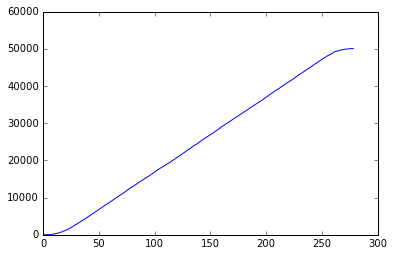

In [5]:
clear_buffer()

channel = 2

pos_query = [('C', channel)]
cmd_pos = 50000
send_command('P', channel, cmd_pos)

pos = send_queries(pos_query)
pos_array = [pos]

while True:
    pos = send_queries(pos_query)
    pos_array.append(pos)
    if pos[0] == cmd_pos:
        break
    if send_query('DR', channel)[0]:
        break
        
plt.plot(pos_array)

# Multiple Axes Position Command Example

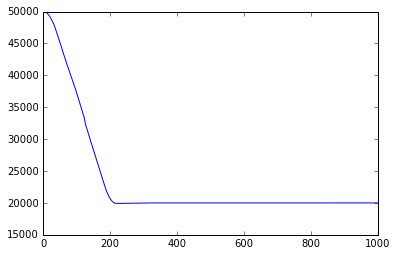

In [6]:
def query_position():
    u.writeStr('?C 1_?C 2_')
    response = ''
    while response.count('\r') != 2:
        response += u.readStr(1)
        
    response = response.replace('\r', ';')[:-1].replace('C=', '').split(';')
    return [int(v) for v in response]

def send_joint_command(pos1, pos2):
    command = '!P 1 %s_!P 2 %s_' % (pos1, pos2)
    u.writeStr(command)
    while not u.dataAvailable():
        pass
    response = ''
    while response != '+\r+\r':
        response += u.readStr(1)

pos1_history = []
pos2_history = []
send_joint_command(-20000, 20000)
test = 0
while True:
    pos1, pos2 = query_position()
    pos1_history.append(pos1)
    pos2_history.append(pos2)
    test += 1
    if test > 1000:
        break

plt.figure()
plt.plot(pos1_history)

plt.figure()
plt.plot(pos2_history)